# **Développement d'une preuve de concept**

## **Importation des packtages et des données**

In [6]:
!pip install transformers nlpaug dgl torch
!pip install torch
!pip install tensorflow
!pip install scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [7]:
import time
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm import tqdm
import multiprocessing
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
from transformers import AutoModel
import nlpaug.augmenter.word as naw
from sklearn.pipeline import Pipeline
from transformers import AutoTokenizer
from sklearn.multioutput import ClassifierChain
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import ParameterGrid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, jaccard_score

In [8]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Projet 5/QueryResults.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Minification failed. Returning unminified cont...,<p>I have made my first website using MVC 5 wh...,|asp.net|asp.net-mvc|bundling-and-minification|,24395412,40,49177,0.0,12
1,Where should ajax request be made in Flux app?,<p>I'm creating a react.js application with fl...,|javascript|reactjs|reactjs-flux|,26632415,199,40698,0.0,6
2,Gem Install Debugger Error,<p>I am running Rails v4.0.2 on Mac OS 10.9.2 ...,|ruby-on-rails|ruby|rubygems|rvm|,24395453,25,28278,0.0,6
3,How to Change body parser limit in Firebase?,<p>I'm trying to proxy a file upload to fireba...,|node.js|express|firebase|google-cloud-functio...,45489810,7,946,NaN,1
4,iOS Android Material Design Hierarchical Timin...,<p>I want to do the animation introduced by An...,|ios|uicollectionview|calayer|material-design|,26632893,11,895,0.0,3


## **Informations générales sur les données**

In [4]:
df.shape

(50000, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          50000 non-null  object 
 1   Body           50000 non-null  object 
 2   Tags           50000 non-null  object 
 3   Id             50000 non-null  int64  
 4   Score          50000 non-null  int64  
 5   ViewCount      50000 non-null  int64  
 6   FavoriteCount  42355 non-null  float64
 7   AnswerCount    50000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.1+ MB


In [6]:
df.nunique()

Title            50000
Body             50000
Tags             39393
Id               50000
Score              805
ViewCount        30183
FavoriteCount        3
AnswerCount         80
dtype: int64

In [7]:
df.columns

Index(['Title', 'Body', 'Tags', 'Id', 'Score', 'ViewCount', 'FavoriteCount',
       'AnswerCount'],
      dtype='object')

In [8]:
df.isnull().sum()

Title               0
Body                0
Tags                0
Id                  0
Score               0
ViewCount           0
FavoriteCount    7645
AnswerCount         0
dtype: int64

In [9]:
df.duplicated(subset=['Title', 'Body', 'Tags']).sum()

0

## **Description de la base de données**

In [10]:
df.describe(include=object)

,Title,Body,Tags
count,50000,50000,50000
unique,50000,50000,39393
top,Minification failed. Returning unminified cont...,<p>I have made my first website using MVC 5 wh...,|javascript|
freq,1,1,180


In [11]:
df.describe(include=np.number)

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,5.000000e+04,50000.000000,5.000000e+04,42355.000000,50000.000000
mean,2.392697e+07,35.912840,3.960468e+04,0.005336,4.340360
std,1.908143e+07,169.205425,1.371497e+05,1.093288,5.143497
min,4.000000e+00,6.000000,3.000000e+01,0.000000,1.000000
25%,6.545710e+05,7.000000,4.103750e+03,0.000000,2.000000
50%,2.113953e+07,11.000000,1.111500e+04,0.000000,3.000000
75%,4.012100e+07,22.000000,2.982225e+04,0.000000,5.000000
max,6.601719e+07,11317.000000,6.047409e+06,225.000000,296.000000


In [12]:
result = df[['Title', 'Body', 'Tags']].applymap(lambda x: len(str(x)))
print(result)

<ipython-input-12-b77276fa704b>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result = df[['Title', 'Body', 'Tags']].applymap(lambda x: len(str(x)))


       Title  Body  Tags
0         50  2812    47
1         46   209    33
2         26  5523    33
3         44  2699    61
4         70   431    46
...      ...   ...   ...
49995     33   595    12
49996     72  1469    28
49997     58  1492    50
49998     45   594    47
49999     56   634    20

[50000 rows x 3 columns]


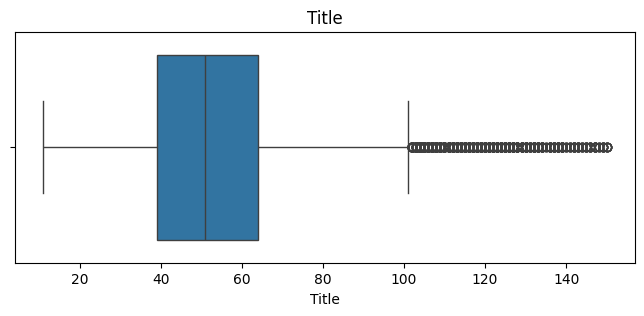

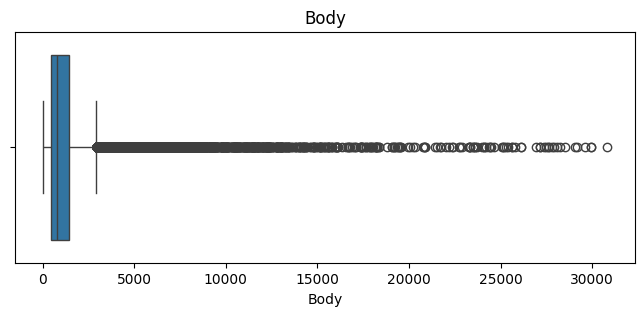

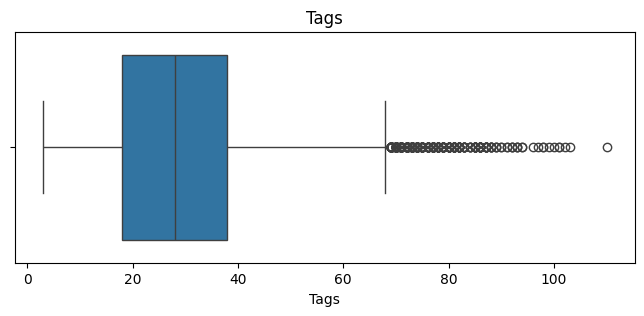

In [13]:
for column in result.columns:
    fig, ax = plt.subplots(figsize=(8, 3))
    sns.boxplot(x=result[column], ax=ax)
    plt.title(column)
    plt.show()

### **Distribution des Tags**

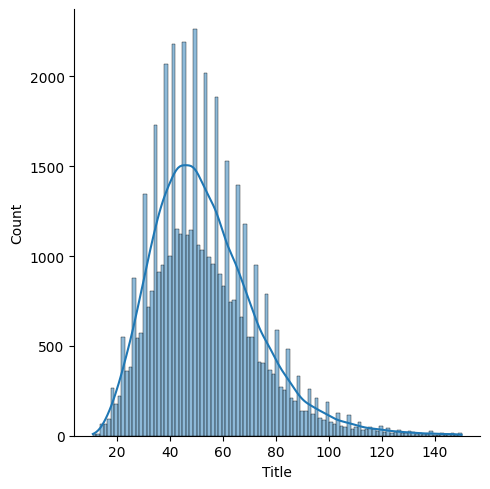

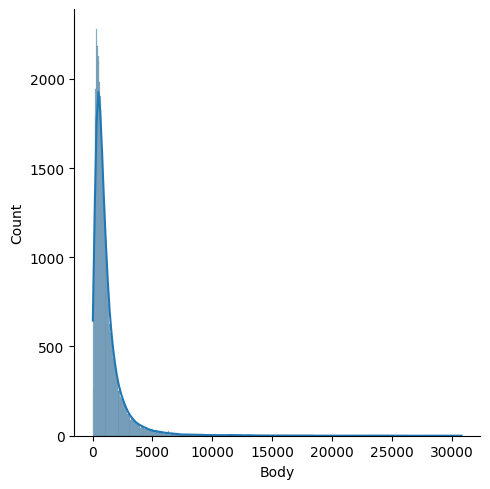

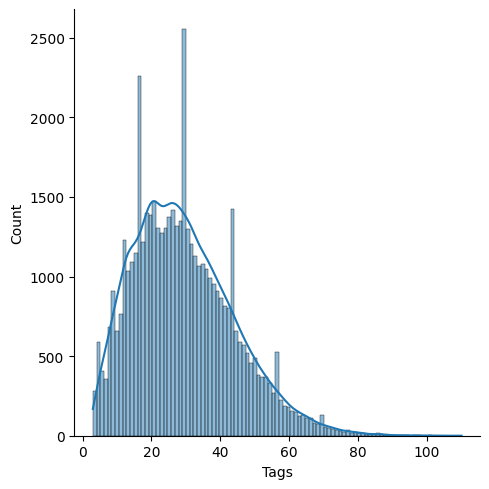

In [14]:
for col in result:
    sns.displot(result[col], kde=True)
    plt.show()

In [15]:
tags, nested_tags = [], []
for i in range(len(df)):
  tags.append(df["Tags"].iloc[i].split('|'))
for tag in tags:
  for subtag in tag:
    if subtag !="":
      nested_tags.append(subtag)

df_tags =  pd.DataFrame(nested_tags).rename(columns={0:"tags"})
df_tags = df_tags["tags"].value_counts().reset_index().sort_values("count", ascending=False)

In [16]:
df_tags

,tags,count
0,python,4571
1,c#,4359
2,javascript,4044
3,java,4039
4,c++,2581
...,...,...
9610,eslintrc,1
9609,cells,1
9608,axios-retry,1
9607,pywinauto,1


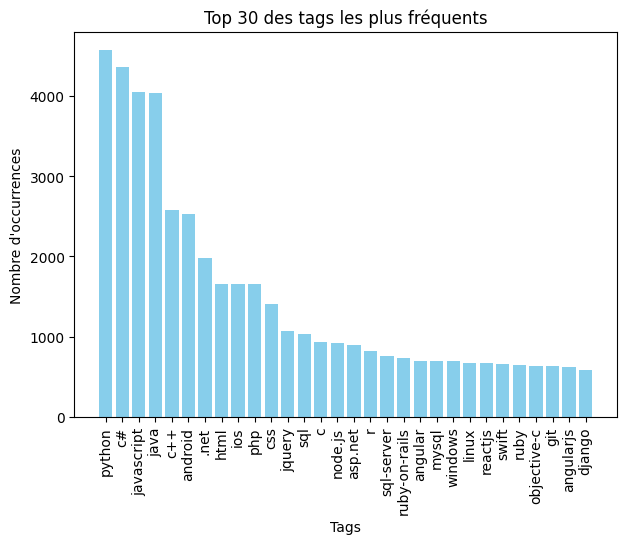

In [17]:
# Trier la DataFrame par les comptes en ordre décroissant
df_tags_sorted = df_tags.sort_values(by="count", ascending=False)

# Sélectionner les 30 tags les plus fréquents
top_30_tags = df_tags_sorted.head(30)

# Représenter un graphique à barres
plt.figure(figsize=(7, 5))
plt.bar(top_30_tags["tags"], top_30_tags["count"], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Tags')
plt.ylabel('Nombre d\'occurrences')
plt.title('Top 30 des tags les plus fréquents')
plt.show()

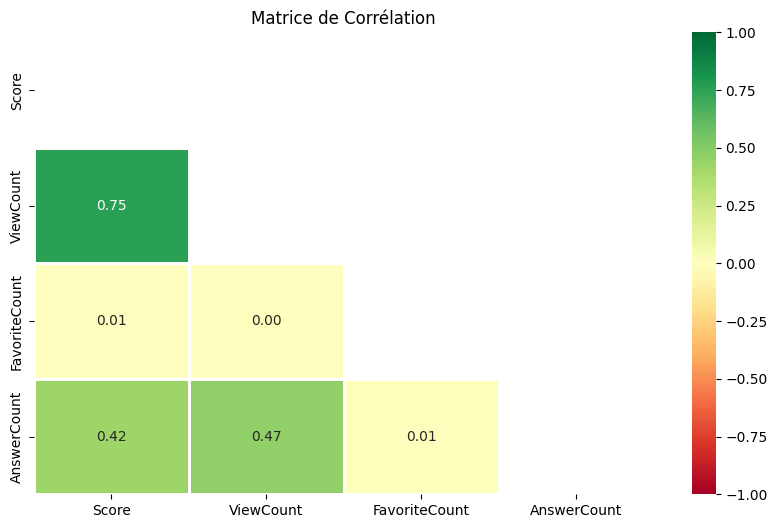

In [18]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Calculer la matrice de corrélation
correlation_matrix = df[numeric_cols].drop('Id', axis=1).corr()

# Afficher la heatmap de la matrice de corrélation
plt.figure(figsize=(10, 6))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, center=0, cmap='RdYlGn',
            linewidths=1, annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show()

## **Text Processing (nettoyage et data feature engineering)**

In [19]:
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

In [20]:
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### **Création d'une fonction pour le text processing**

In [21]:
def clean_text(text,
               rejoin=False,
               list_rare_words=None,
               min_len_word=3,
               force_is_alpha=True,
               eng_worsd=None):
  """
    Nettoie et prétraite une chaîne de texte donnée en effectuant plusieurs tâches de traitement du langage naturel telles que
    la suppression des balises HTML, la conversion du texte en minuscules, la tokenisation, la suppression des stopwords,
    la suppression des mots rares, le filtrage des tokens par longueur, l'assurance que les tokens sont alphabétiques, et la lemmatisation.

    Paramètres:
    text (str): Le texte d'entrée à nettoyer.
    rejoin (bool): Indique s'il faut réassembler les tokens en une seule chaîne après le traitement. Par défaut, False.
    list_rare_words (list): Une liste de mots rares à supprimer du texte. Par défaut, None.
    min_len_word (int): La longueur minimale d'un mot pour qu'il soit conservé dans le texte. Par défaut, 3.
    force_is_alpha (bool): Indique s'il faut forcer les tokens à être alphabétiques. Les tokens non alphabétiques seront supprimés si ce paramètre est True. Par défaut, True.
    eng_worsd (list): Une liste optionnelle de mots supplémentaires à considérer comme des stopwords. Par défaut, None.

    Retourne:
    str: Le texte nettoyé et prétraité.
    """
  if not list_rare_words:
    list_rare_words = []
    # Supprimer les balises HTML
    text = BeautifulSoup(text, "html.parser").get_text()

    # Convertir en minuscules
    text = text.lower().strip()

    # Tokenisation
    tokenizer = RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(text)

    # Supprimer les stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    #
    non_rare_tokens = [w for w in filtered_tokens if w not in list_rare_words]
    #
    more_than_N = [w for w in non_rare_tokens if len(w) >=min_len_word]
    #
    if force_is_alpha:
      alpha_tokens= [w for w in more_than_N if w.isalpha()]
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in alpha_tokens]
    # Rejoindre les tokens en texte
    cleaned_text = ' '.join(lemmatized_tokens)
    return cleaned_text

### **Application de la focntion aux colonnes concernées**

In [22]:
df['Title'] = df['Title'].apply(clean_text)
df['Body'] = df['Body'].apply(clean_text)

<ipython-input-21-d5a548d22908>:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [23]:
df

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,minification failed returning unminified content,made first website using mvc work fine local m...,|asp.net|asp.net-mvc|bundling-and-minification|,24395412,40,49177,0.0,12
1,ajax request made flux app,creating react application flux architecture t...,|javascript|reactjs|reactjs-flux|,26632415,199,40698,0.0,6
2,gem install debugger error,running rail mac everything smoothly sudden ge...,|ruby-on-rails|ruby|rubygems|rvm|,24395453,25,28278,0.0,6
3,change body parser limit firebase,trying proxy file upload firebase cloud functi...,|node.js|express|firebase|google-cloud-functio...,45489810,7,946,NaN,1
4,io android material design hierarchical timing...,want animation introduced android material des...,|ios|uicollectionview|calayer|material-design|,26632893,11,895,0.0,3
...,...,...,...,...,...,...,...,...
49995,make toolbar grid layout,want make qtoolbar column button docked left s...,|c++|qt|qt5|,23638595,7,2137,NaN,1
49996,using jmslistener multiple payload type destin...,write instance multiple type given destination...,|java|spring|jms|spring-jms|,42656519,6,6453,0.0,3
49997,testing resolved data test ngoninit,working testing guide wish write test ngoninit...,|javascript|angular|jasmine|karma-runner|resol...,42656045,34,67797,0.0,2
49998,unit test project reference mvc project,perhaps easier let visual studio create unit t...,|unit-testing|visual-studio-2013|asp.net-mvc-5|,23638602,10,7610,0.0,4


### **Visualisation avec Wordcloud**

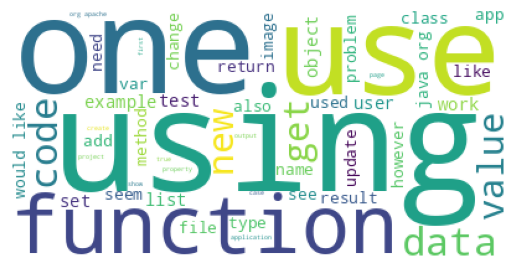

In [24]:
wordcloud = WordCloud(background_color='white',
                      stopwords= [],
                      max_words=50).generate(" ".join(df['Body']+ df['Title']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

## **Modélisation supervisée avec Logistic Classifier**

In [25]:
data = df.copy()

### **Préparation de la variable cible**

In [26]:
tags, nested_tags = [], []
# recuperer top k des tags importants
for i in range(len(data)):
  tags.append(data["Tags"].iloc[i].split('|'))
for tag in tags:
  for subtag in tag:
    if subtag !="":
      nested_tags.append(subtag)

df_tags =  pd.DataFrame(nested_tags).rename(columns={0:"tags"})
df_tags = df_tags["tags"].value_counts().reset_index().sort_values("count", ascending=False)
real_tags = df_tags.head(10)["tags"].tolist()

In [27]:
# transformer le contenu de tag en list de simple tag
data['filtered_tags'] = data['Tags'].str.split("|")

In [28]:
# strip les virgules au debut des tags
def strip_and_filter_commas(tag_list):
    return [tag.strip(',') for tag in tag_list if tag.strip(',')]
data['filtered_tags'] = data['filtered_tags'].apply(strip_and_filter_commas)

In [29]:
# Vérifier si chaque ligne de 'filtered_tags' contient au moins un élément de 'real_tags'
data['contains_real_tag'] = data['filtered_tags'].apply(lambda x: any(tag in x for tag in real_tags))

In [30]:
# garder les tags pertinents et remplacer par others si impertinents
allowed_tags = real_tags

def filter_tags(tag_list):
    if any(tag in allowed_tags for tag in tag_list):
        return [tag for tag in tag_list if tag in allowed_tags]
    else:
        return ["Others"]


data['filtered_tags'] = data['filtered_tags'].apply(filter_tags)
data['filtered_tags'].head()

0        [Others]
1    [javascript]
2        [Others]
3        [Others]
4           [ios]
Name: filtered_tags, dtype: object

## **Encodage et séparation des données en trainset et testset**

In [31]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(data['filtered_tags'])
y = mlb.transform(data['filtered_tags'])

In [32]:
X = data[['Title', 'Body']].apply(lambda x: ' '.join(x), axis=1)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

In [33]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Recherche des meilleurs hyperparamètres**

In [34]:
# Définir la grille de paramètres
param_grid_logistic = {
    "max_iter": [500, 1000],
    "penalty": ['l1', 'l2'],
    "solver": ['liblinear'],
}

# Liste pour stocker les résultats
results = []

# Loop over parameter grid
for params in ParameterGrid(param_grid_logistic):
    # Instantiate model with current set of hyperparameters
    base_model = LogisticRegression(**params)
    model_logistic = OneVsRestClassifier(base_model)

    # Train the model
    start_time = time.time()
    model_logistic.fit(X_train, y_train)
    end_time = time.time()

    # Make predictions
    y_pred = model_logistic.predict(X_test)

    # Calculate metrics
    jaccard = jaccard_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Log metrics
    results.append({
        "params": params,
        "Jaccard": round(jaccard, 2),
        "accuracy": round(accuracy, 2),
        "precision": round(precision, 2),
        "recall": round(recall, 2),
        "f1": round(f1, 2),
        "training_time": end_time - start_time
    })

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                                              params  Jaccard  accuracy  \
0  {'max_iter': 500, 'penalty': 'l1', 'solver': '...      0.5      0.55   
1  {'max_iter': 500, 'penalty': 'l2', 'solver': '...      0.5      0.54   
2  {'max_iter': 1000, 'penalty': 'l1', 'solver': ...      0.5      0.55   
3  {'max_iter': 1000, 'penalty': 'l2', 'solver': ...      0.5      0.54   

   precision  recall    f1  training_time  
0       0.71    0.63  0.66      99.431603  
1       0.70    0.62  0.66     359.805779  
2       0.71    0.63  0.66     136.529005  
3       0.70    0.62  0.66     366.356783  


### **Affichage des meilleurs hyperparamètres et réentraînement du modèle avec ces meilleurs hyperparamètres**

In [35]:
# Find the best hyperparameters based on a chosen metric, e.g., accuracy
best_result = results_df.loc[results_df['accuracy'].idxmax()]
best_params = best_result['params']
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}


In [36]:
# Re-train the model with the best hyperparameters
best_base_model = LogisticRegression(**best_params)
best_model_logistic = OneVsRestClassifier(best_base_model)

# Train the best model
best_model_logistic.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


OneVsRestClassifier(estimator=LogisticRegression(max_iter=500, penalty='l1',
                                                 solver='liblinear'))

### **Evaluation du meilleur modèle**

In [37]:
# Make predictions with the best model
y_pred_best = best_model_logistic.predict(X_test)

# Calculate and print metrics for the best model
jaccard_best = jaccard_score(y_test, y_pred_best, average='weighted')
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, average='weighted')
recall_best = recall_score(y_test, y_pred_best, average='weighted')
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print(f"Best Model Metrics:\n"
      f"Jaccard: {round(jaccard_best, 2)}\n"
      f"Accuracy: {round(accuracy_best, 2)}\n"
      f"Precision: {round(precision_best, 2)}\n"
      f"Recall: {round(recall_best, 2)}\n"
      f"F1: {round(f1_best, 2)}")

Best Model Metrics:
Jaccard: 0.5
Accuracy: 0.55
Precision: 0.71
Recall: 0.63
F1: 0.66


## **Développment d'une technique récente**

In [38]:
# Prendre un échantillon de 10 % des données
df_sampled = df.sample(frac=0.1, random_state=42)

# Copier les données échantillonnées
DATA = df_sampled.copy()

In [39]:
tags, nested_tags = [], []
# recuperer top k des tags importants
for i in range(len(DATA)):
  tags.append(DATA["Tags"].iloc[i].split('|'))
for tag in tags:
  for subtag in tag:
    if subtag !="":
      nested_tags.append(subtag)

df_tags =  pd.DataFrame(nested_tags).rename(columns={0:"tags"})
df_tags = df_tags["tags"].value_counts().reset_index().sort_values("count", ascending=False)
real_tags = df_tags.head(10)["tags"].tolist()

In [40]:
# transformer le contenu de tag en list de simple tag
DATA['filtered_tags'] = DATA['Tags'].str.split("|")

In [41]:
# strip les virgules au debut des tags
def strip_and_filter_commas(tag_list):
    return [tag.strip(',') for tag in tag_list if tag.strip(',')]
DATA['filtered_tags'] = DATA['filtered_tags'].apply(strip_and_filter_commas)

In [42]:
# Vérifier si chaque ligne de 'filtered_tags' contient au moins un élément de 'real_tags'
DATA['contains_real_tag'] = DATA['filtered_tags'].apply(lambda x: any(tag in x for tag in real_tags))

In [43]:
# garder les tags pertinents et remplacer par others si impertinents
allowed_tags = real_tags

def filter_tags(tag_list):
    if any(tag in allowed_tags for tag in tag_list):
        return [tag for tag in tag_list if tag in allowed_tags]
    else:
        return ["Others"]


DATA['filtered_tags'] = DATA['filtered_tags'].apply(filter_tags)
DATA['filtered_tags'].head()

33553        [c#]
9427     [Others]
199      [Others]
12447    [Others]
39489    [Others]
Name: filtered_tags, dtype: object

In [44]:
# Concaténer le titre et le corps
DATA['text'] = DATA['Title'] + ' ' + DATA['Body']

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import nlpaug.augmenter.word as naw
import torch.optim as optim
from tqdm import tqdm

# Data augmentation
augmenter = naw.SynonymAug(aug_src='wordnet')
augmented_texts = augmenter.augment(DATA['text'].tolist())
augmented_data = DATA.copy()
augmented_data['text'] = augmented_texts

# Combine original and augmented data
combined_data = pd.concat([DATA, augmented_data])

# Split data
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=42)

In [46]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
max_length = 64

def tokenize_function(texts, tokenizer, max_length):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

train_encodings = tokenize_function(train_data['text'].tolist(), tokenizer, max_length)
test_encodings = tokenize_function(test_data['text'].tolist(), tokenizer, max_length)

# Binarization
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data['filtered_tags'])
y_test = mlb.transform(test_data['filtered_tags'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [47]:
# Dataset
class SOFDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SOFDataset(train_encodings, y_train)
test_dataset = SOFDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [48]:
# Model
class SciBERTCNN(nn.Module):
    def __init__(self, num_labels, max_length):
        super(SciBERTCNN, self).__init__()
        self.scibert = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=5, padding=2)
        self.max_pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(64 * (max_length // 2 // 2), 64)
        self.fc2 = nn.Linear(64, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.scibert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state.permute(0, 2, 1)
        x = self.conv1(last_hidden_state)
        x = torch.relu(x)
        x = self.max_pool(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.max_pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits

model = SciBERTCNN(num_labels=len(mlb.classes_), max_length=max_length)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-5)

# Utiliser un scheduler pour le taux d'apprentissage
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [51]:
# Training
for epoch in range(4):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Average training loss for epoch {epoch + 1}: {avg_train_loss}")

    scheduler.step(avg_train_loss)

    # Evaluation
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating Epoch {epoch + 1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds.append(outputs.cpu())
            true_labels.append(labels.cpu())

    preds = torch.cat(preds, dim=0)
    true_labels = torch.cat(true_labels, dim=0)
    preds = (torch.sigmoid(preds) > 0.5).int().numpy()
    true_labels = true_labels.numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='micro')
    acc = accuracy_score(true_labels, preds)
    print(f"Evaluation metrics for epoch {epoch + 1}: Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}")

# Sauvegarder l'état du modèle, de l'optimiseur, et du scheduler
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': avg_train_loss,
}, 'checkpoint.pth')

Training Epoch 1: 100%|██████████| 250/250 [1:19:25<00:00, 19.06s/it]


Average training loss for epoch 1: 0.1548189419209957


Evaluating Epoch 1: 100%|██████████| 63/63 [06:16<00:00,  5.97s/it]


Evaluation metrics for epoch 1: Accuracy: 0.4255, Precision: 0.8232514177693762, Recall: 0.4089201877934272, F1: 0.5464240903387704


Training Epoch 2: 100%|██████████| 250/250 [1:19:04<00:00, 18.98s/it]


Average training loss for epoch 2: 0.13451868516206741


Evaluating Epoch 2: 100%|██████████| 63/63 [06:14<00:00,  5.95s/it]


Evaluation metrics for epoch 2: Accuracy: 0.5785, Precision: 0.786692759295499, Recall: 0.5661971830985916, F1: 0.6584766584766585


Training Epoch 3: 100%|██████████| 250/250 [1:19:23<00:00, 19.05s/it]


Average training loss for epoch 3: 0.11347740778326988


Evaluating Epoch 3: 100%|██████████| 63/63 [06:16<00:00,  5.97s/it]


Evaluation metrics for epoch 3: Accuracy: 0.619, Precision: 0.7626728110599078, Recall: 0.6215962441314554, F1: 0.6849456802897051


Training Epoch 4: 100%|██████████| 250/250 [1:19:22<00:00, 19.05s/it]


Average training loss for epoch 4: 0.10107250820100308


Evaluating Epoch 4: 100%|██████████| 63/63 [06:16<00:00,  5.97s/it]


Evaluation metrics for epoch 4: Accuracy: 0.6915, Precision: 0.8080918534718425, Recall: 0.6938967136150235, F1: 0.7466531952513261


In [1]:
# Spécifier le chemin de sauvegarde dans Google Drive
save_path = '/content/drive/MyDrive/checkpoint.pth'

# Exemple de dictionnaire de paramètres du modèle
model_params = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': avg_train_loss,
}

# Sauvegarder le modèle
torch.save(model_params, save_path)
print(f"Modèle sauvegardé dans {save_path}")

NameError: name 'epoch' is not defined